# SFT Data Preparation

## Finding embeddings for DEPlain data

In [4]:
# run pre_sft.py with GPU access
# this creates embeddings for all DEPlain sentences

# embedding model is:
# 'T-Systems-onsite/cross-en-de-roberta-sentence-transformer'

## Finding legal SFT based on Rouge, Cosine Similarity of DEPlain data

In [5]:
%load_ext autoreload
%autoreload 2
from utils import base_dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

deplain_data = pd.DataFrame(base_dependencies.load_jsonl('data/deplain_sentences/all_w_embeddings.jsonl'))
deplain_data['similarity'] = deplain_data.apply(lambda row: base_dependencies.cossim(row['original_embeddings'], row['simplification_embeddings']), axis=1)
originals = list(deplain_data['original'])
simplifications = list(deplain_data['simplification'])
len(originals), len(simplifications)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(13122, 13122)

In [7]:
len(originals) - len(deplain_data[deplain_data['alignment'].str.contains('1:')])

850

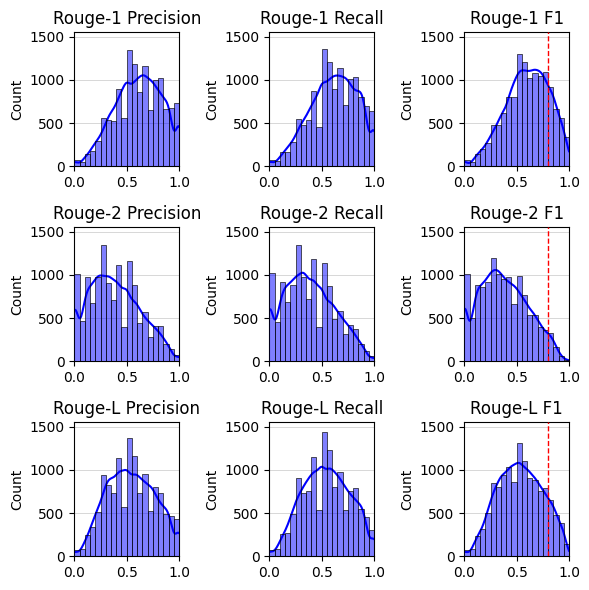

In [8]:
results = base_dependencies.pull_rouge(originals, simplifications)
deplain_data_copy = deplain_data.copy()
deplain_data_copy['rouge'] = results

for var in ['rouge1', 'rouge2', 'rougeL']:
    deplain_data_copy[f'{var}_p'] = deplain_data_copy['rouge'].apply(lambda x: x[var][0])
    deplain_data_copy[f'{var}_r'] = deplain_data_copy['rouge'].apply(lambda x: x[var][1])
    deplain_data_copy[f'{var}_f'] = deplain_data_copy['rouge'].apply(lambda x: x[var][2])

deplain_data_copy = deplain_data_copy.drop(columns=['rouge'])

base_dependencies.chart_rouge(results)

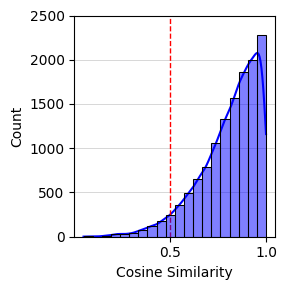

In [9]:
plt.figure(figsize=(3,3))
sns.histplot(deplain_data_copy['similarity'], kde=True, color='blue', bins=20, edgecolor='black', zorder=4)
plt.xlabel('Cosine Similarity')
plt.title('')
plt.grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=0.7, zorder=0)
ax = plt.gca()  # Get current axes
ax.set_ylim([0, 2500])
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500])
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig('figures/deplain_presft_cossim.png', dpi=800)
plt.show()

In [10]:
deplain_data_copy[deplain_data_copy['rougeL_f'] == 1][['original', 'simplification']].values[2]

array(['Integration bedeutet, also dass jemand dazugehört.',
       'Integration bedeutet also, dass jemand dazugehört.'], dtype=object)

In [11]:
len(deplain_data_copy[deplain_data_copy['similarity'] < 0.5])

614

In [12]:
deplain_data_copy['illegal'] = ((deplain_data_copy['rouge1_f'] > 0.8) | (deplain_data_copy['rouge2_f'] > 0.8) | (deplain_data_copy['rougeL_f'] > 0.8))
deplain_data_copy.illegal.value_counts()

False    10762
True      2360
Name: illegal, dtype: int64

In [13]:
a = len(deplain_data_copy)
print(a)
tmp = deplain_data_copy[deplain_data_copy['alignment'].str.contains('1:')]
b = len(tmp)
print('alignment drop', a - b, ",", b)
tmp = tmp[tmp['similarity'] >= 0.5]
c = len(tmp)
print('cossim drop ', b - c, ",", c)
tmp['illegal'] = ((tmp['rouge1_f'] <= 0.8) & (tmp['rouge2_f'] <= 0.8) & (tmp['rougeL_f'] <= 0.8))
tmp = tmp[tmp['illegal'] == 1]
d = len(tmp)
print('rouge drop ', c - d, ",", d)
#tmp['alignment'].value_counts()


13122
alignment drop 850 , 12272
cossim drop  591 , 11681
rouge drop  2322 , 9359


In [14]:
a = len(deplain_data_copy)
print(a)
tmp = deplain_data_copy[deplain_data_copy['alignment'].str.contains('1:')]
b = len(tmp)
print('alignment drop', a - b, ",", b)
tmp = deplain_data_copy[deplain_data_copy['similarity'] >= 0.5]
c = len(tmp)
print('cossim drop ', a - c, ",", c)
tmp = deplain_data_copy[((deplain_data_copy['rouge1_f'] <= 0.8) & (deplain_data_copy['rouge2_f'] <= 0.8) & (deplain_data_copy['rougeL_f'] <= 0.8))]
d = len(tmp)
print('rouge drop ', a - d, ",", d)
#tmp['alignment'].value_counts()

13122
alignment drop 850 , 12272
cossim drop  614 , 12508
rouge drop  2360 , 10762


In [15]:
deplain_data_copy['illegal'] = ((deplain_data_copy['rouge1_f'] > 0.8) | (deplain_data_copy['rouge2_f'] > 0.8) | (deplain_data_copy['rougeL_f'] > 0.8) | (deplain_data_copy['similarity'] < 0.5)).astype(int)
nonrep_and_sim = deplain_data_copy[deplain_data_copy['illegal'] == 0].reset_index(drop=True)[['original', 'simplification', 'similarity', 'alignment']]

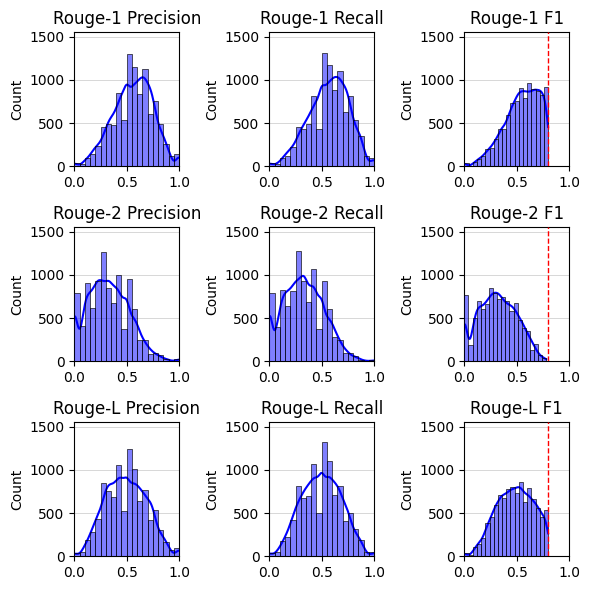

In [16]:
results2 = base_dependencies.pull_rouge(list(nonrep_and_sim['original']), list(nonrep_and_sim['simplification']))
base_dependencies.chart_rouge(results2)

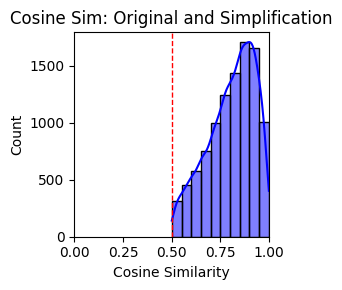

In [17]:
plt.figure(figsize=(3,3))
sns.histplot(nonrep_and_sim['similarity'], kde=True, color='blue', bins=10, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.title('Cosine Sim: Original and Simplification')
plt.xlim(0,1)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

In [18]:
# alignment must be from 1 sentence to 1 or more sentences
legal = nonrep_and_sim[nonrep_and_sim['alignment'].str.contains('1:')]

In [19]:
legal.iloc[0][['original', 'simplification']].values

array(['Am Mittwoch hat der Iran bekanntgegeben, dass er teilweise aus dem Atom-Abkommen aussteigt.',
       'Der Iran wird teilweise aus dem Atom-Abkommen aussteigen.'],
      dtype=object)

In [20]:
# commented out only because unsure about original order; don't want reorder to affect sampling later
# legal.to_json('data/sft_legal.jsonl', orient='records', lines=True)

In [21]:
sim_sub_5 = deplain_data_copy
#origs = list(sim_sub_5['original'])
#simps = list(sim_sub_5['simplification'])
#for i in range(len(origs)):
#    print(origs[i], '||', simps[i])

In [22]:
illegal = deplain_data_copy[deplain_data_copy['illegal'] == 1].reset_index(drop=True)

# high rouge example
illegal.iloc[1][['original', 'simplification']].values

# low similarity example
illegal[illegal['original'] == 'Es gibt aber große Unterschiede.']['simplification'].values

array(['Nicht in jedem Vanille-Eis ist gleich viel Luft drin.'],
      dtype=object)

## Exploring DEplain dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
13122
9415


C:\Users\HP\AppData\Local\Temp\ipykernel_25816\1235369823.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_df['wc'] = base_dependencies.wcs(pairs_df['original'])


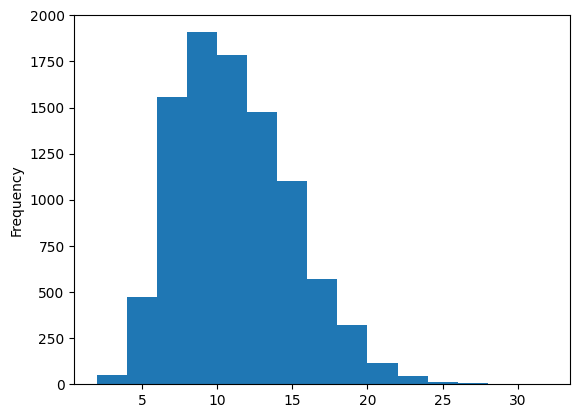

In [23]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import random
from utils import base_dependencies

deplain_all = pd.read_csv("data/deplain_sentences/all.csv")
deplain_legal = pd.DataFrame(base_dependencies.load_jsonl('data/sft_legal.jsonl'))

def dist_len_sing_legal_sentences(pairs_df, deplain_legal):
    print(len(pairs_df))
    pairs_df = pairs_df[pairs_df['original'].isin(deplain_legal['original'])]
    print(len(pairs_df))
    pairs_df['wc'] = base_dependencies.wcs(pairs_df['original'])
    pairs_df['wc'].plot(kind='hist', bins=15)
    plt.show()

dist_len_sing_legal_sentences(deplain_all, deplain_legal)

## Sample and save DEPlain to SFT datasets
### (incl. using DEPlain for 1- and 2-shot learning in prompts)

In [24]:
import numpy as np
import os

def sample_for_sft(deplain_df, deplain_legal, deplain_filtervars):

    random.seed(5)

    deplain_df = deplain_df.rename(columns={'simplification':'completion'})
    deplain_df['prompt'] = deplain_df['original']
    deplain_df = deplain_df[deplain_df['alignment'].str[0] == '1']
    deplain_df = deplain_df[deplain_df['original'].isin(deplain_legal['original'])]
    print('size base:', len(deplain_df), len(deplain_df['original'].unique()))
    deplain_df['wc'] = base_dependencies.wcs(deplain_df['original'])
    deplain_df['simp_wc'] = base_dependencies.wcs(deplain_df['completion'])
    sigma = 3  # Controls the spread of the weight function
    deplain_df['gaussian'] = np.exp(-((deplain_df['wc'] - 15) ** 2) / (2 * sigma ** 2))


    deplain_df = deplain_df[deplain_df['simp_wc'] <= 30]
    deplain_df = deplain_df[deplain_df['wc'] <= 30]
    
    print(len(deplain_df))
    deplain_sample = deplain_df.sample(n=5200, weights='gaussian', random_state=55)

    deplain_leftover = deplain_df.loc[~deplain_df.index.isin(deplain_sample.index)]
    deplain_leftover = deplain_leftover.sample(frac=1, random_state = 5)

    print('size sample:', len(deplain_sample), len(deplain_sample['original'].unique()))
    print('total leftovers:', len(deplain_leftover))
    
    leftovers = deplain_leftover[['original', 'completion']].to_dict(orient='records')
    left_start = len(leftovers)
    print(len(deplain_sample), 'instances to cover ~3/10 of')

    deplain_instances = deplain_sample.to_dict(orient='records')

    for instance_dict in deplain_instances:
        instance_dict['prompt'], leftovers = base_dependencies.select_prompt(instance_dict['original'], "sft", "rand", leftovers)

    print('took', left_start - len(leftovers), 'leftovers')
    deplain_sample = pd.DataFrame(deplain_instances)[['original', 'prompt', 'completion']]

    deplain_sample = deplain_sample.sample(frac=1, random_state=5)
    deplain_holdout = deplain_sample[0:800]
    deplain_dev = deplain_sample[800:1600]
    deplain_train = deplain_sample[1600:5200]

    print(len(deplain_train['original'].unique()), len(deplain_holdout['original'].unique()), len(deplain_dev['original'].unique()))

    deplain_filtervars = deplain_filtervars.rename(columns={'simplification':'completion'})
    deplain_filtervars = deplain_filtervars[['original', 'completion', 'similarity', 'rouge1_f', 'rouge2_f', 'rougeL_f']]


    tmp = pd.merge(deplain_train, deplain_filtervars, how='left', on=['original', 'completion'])
    print('train contamination: ', len(tmp[tmp['similarity'] < 0.5]))
    print('train contamination: ', len(tmp[((tmp['rouge1_f'] > 0.8) | (tmp['rouge2_f'] > 0.8) | (tmp['rougeL_f'] > 0.8))]))
    tmp = pd.merge(deplain_dev, deplain_filtervars, how='left', on=['original', 'completion'])
    print('dev contamination: ', len(tmp[tmp['similarity'] < 0.5]))
    print('dev contamination: ', len(tmp[((tmp['rouge1_f'] > 0.8) | (tmp['rouge2_f'] > 0.8) | (tmp['rougeL_f'] > 0.8))]))
    tmp = pd.merge(deplain_holdout, deplain_filtervars, how='left', on=['original', 'completion'])
    print('holdout contamination: ', len(tmp[tmp['similarity'] < 0.5]))
    print('holdout contamination: ', len(tmp[((tmp['rouge1_f'] > 0.8) | (tmp['rouge2_f'] > 0.8) | (tmp['rougeL_f'] > 0.8))]))
    tmp = pd.merge(deplain_leftover[['original', 'completion']], deplain_filtervars, how='left', on=['original', 'completion'])
    print('leftover contamination: ', len(tmp[tmp['similarity'] < 0.5]))
    print('leftover contamination: ', len(tmp[((tmp['rouge1_f'] > 0.8) | (tmp['rouge2_f'] > 0.8) | (tmp['rougeL_f'] > 0.8))]))
    # prompt picker seed set AFTER train - do not overwrite
    #deplain_train.to_json(f'data/sft_train.jsonl', orient='records', lines=True)
    #deplain_dev.to_json(f'data/sft_dev.jsonl', orient='records', lines=True)
    #deplain_holdout.to_json(f'data/sft_holdout.jsonl', orient='records', lines=True)

    print('after prompts,', len(leftovers), 'leftovers')

    all = pd.read_csv("data/deplain_sentences/all.csv")
    all = all[all['alignment'].str[0] == '1']
    all = all[['original', 'simplification']]

    illegal = all[~all['original'].isin(deplain_legal['original'])]
    print('adding back', len(illegal), 'with too high rouge or too low cossim for sft')
    leftovers_plus_illegal = pd.concat([pd.DataFrame(leftovers), illegal], ignore_index=True).reset_index(drop=True)
    print('total leftovers for use beyond sft:', len(leftovers_plus_illegal), len(leftovers_plus_illegal['original'].unique()))
    # prompt picker seed set AFTER train - do not overwrite
    #leftovers_plus_illegal.to_json(f'data/sft_leftovers.jsonl', orient='records', lines=True)

# sample to 3600 train, 800 dev, 800 holdout. save leftovers for use beyond sft
sample_for_sft(deplain_all, deplain_legal, deplain_data_copy)


size base: 9414 9226
9360
size sample: 5200 5122
total leftovers: 4160
5200 instances to cover ~3/10 of
took 1580 leftovers
3568 796 799
train contamination:  0
train contamination:  24
dev contamination:  0
dev contamination:  5
holdout contamination:  0
holdout contamination:  3
leftover contamination:  2
leftover contamination:  21
after prompts, 2580 leftovers
adding back 2858 with too high rouge or too low cossim for sft
total leftovers for use beyond sft: 5438 5374


In [25]:
random.seed(5)

tmp = deplain_all.rename(columns={'simplification':'completion'})
tmp = tmp[tmp['alignment'].str[0] == '1']
tmp = tmp[tmp['original'].isin(deplain_legal['original'])]

deplain_data_copy.columns

Index(['original', 'simplification', 'original_id', 'simplification_id',
       'pair_id', 'domain', 'corpus', 'language_level_original',
       'language_level_simple', 'license', 'author', 'simple_url',
       'complex_url', 'simple_title', 'complex_title', 'access_date', 'rater',
       'alignment', 'original_embeddings', 'simplification_embeddings',
       'similarity', 'rouge1_p', 'rouge1_r', 'rouge1_f', 'rouge2_p',
       'rouge2_r', 'rouge2_f', 'rougeL_p', 'rougeL_r', 'rougeL_f', 'illegal'],
      dtype='object')

## Plot DEPlain Raw and Sample WC Distributions

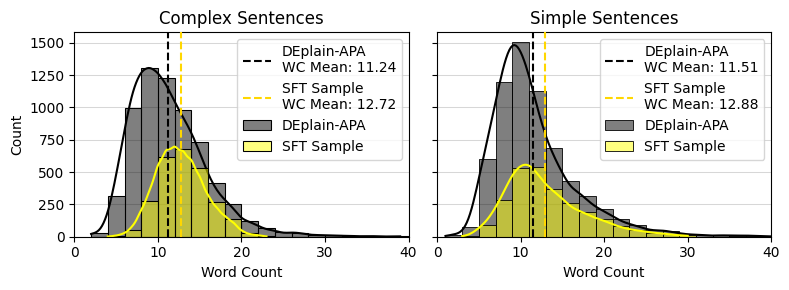

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def prep_wcs(name, orig_or_simp):
    df = pd.DataFrame(base_dependencies.load_jsonl(f'data/sft_{name}.jsonl'))
    wcs = base_dependencies.wcs((df[orig_or_simp]))
    return wcs

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

def plot_wc_histogram(orig_or_simp):
    wcs_all = base_dependencies.wcs(deplain_all[orig_or_simp])
    if orig_or_simp == 'simplification':
        orig_or_simp2 = 'completion'
        col = 1
    else:
        orig_or_simp2 = orig_or_simp
        col = 0

    wcs_all_mean = np.mean(wcs_all)
    bin_width = 2
    bins_all = np.arange(min(wcs_all), max(wcs_all) + bin_width, bin_width)
    bins_train = np.arange(min(prep_wcs('train', orig_or_simp2)), max(prep_wcs('train', orig_or_simp2)) + bin_width, bin_width)
    bins_dev = np.arange(min(prep_wcs('dev', orig_or_simp2)), max(prep_wcs('dev', orig_or_simp2)) + bin_width, bin_width)
    bins_holdout = np.arange(min(prep_wcs('holdout', orig_or_simp2)), max(prep_wcs('holdout', orig_or_simp2)) + bin_width, bin_width)

    if orig_or_simp == 'original':
        oos_title = 'Complex'
    else:
        oos_title = 'Simple'

    all_sample_wcs = prep_wcs('train', orig_or_simp2) + prep_wcs('dev', orig_or_simp2) + prep_wcs('holdout', orig_or_simp2)
    wcs_sample_mean = np.mean(all_sample_wcs)

    wcs_all = [x for x in wcs_all if x <= 40]
    wcs_sample = [x for x in all_sample_wcs if x <= 40]
    
    axes[col].grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.5)
    axes[col].set_axisbelow(True)

    sns.histplot(wcs_all, kde=True, ax=axes[col], color='black', bins=bins_all, edgecolor='black', label='DEplain-APA',stat='frequency', zorder=1)
    axes[col].set_title(f'{oos_title} Sentences')

    sns.histplot(wcs_sample, bins=bins_all, kde=True, ax=axes[col], color='yellow', label='SFT Sample', edgecolor='black', stat='frequency', zorder=2)
    #sns.histplot(prep_wcs('train', orig_or_simp2), bins=bins_train, kde=True, ax=axes[col], color='blue', label='Train', edgecolor='black', stat='density')
    #sns.histplot(prep_wcs('holdout', orig_or_simp2), bins=bins_holdout, kde=True, ax=axes[col], color='green', label='Holdout', edgecolor='black', stat='density')
    #sns.histplot(prep_wcs('dev', orig_or_simp2), bins=bins_dev, kde=True, ax=axes[col], color='orange', label='Dev', edgecolor='black', stat='density')
    axes[col].axvline(wcs_all_mean, color='black', linestyle='--', label=f'DEplain-APA\nWC Mean: {wcs_all_mean:.2f}', zorder=10)
    axes[col].axvline(wcs_sample_mean, color='gold', linestyle='--', label=f'SFT Sample\nWC Mean: {wcs_sample_mean:.2f}', zorder=10)
    axes[col].set_xticks([0, 10, 20, 30, 40])
    axes[col].set_xlim([0, 40])
    axes[col].legend()
    axes[col].set_xlabel('Word Count')
    axes[col].set_ylabel('Count')
    

# Call the function for both complex and simplifications
plot_wc_histogram('original')  # For complex sentences
plot_wc_histogram('simplification')  # For simplifications

plt.tight_layout()
plt.savefig('figures/deplain_presft_wcs.png', dpi=800)
plt.show()


#### Final table figures

In [34]:
train = pd.read_json('data/sft_train.jsonl', lines=True)
dev = pd.read_json('data/sft_dev.jsonl', lines=True)
test = pd.read_json('data/sft_holdout.jsonl', lines=True)

In [35]:
sum(base_dependencies.wcs(train['prompt']) + base_dependencies.wcs(train['completion']))

252285

In [31]:
sum(base_dependencies.wcs(dev['prompt']) + base_dependencies.wcs(dev['completion']))

55208

In [32]:
sum(base_dependencies.wcs(test['prompt']) + base_dependencies.wcs(test['completion']))

55852